In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import data_preprocessing as dp
%matplotlib inline

### Parameters 
Loss: 15
- batch size = 32
- epochs = 5000
- layers = lin2(60), lin3(45)
- lr = 0.01
- noise scale = 0.01
- test size = 30%

# Prepare Data

In [73]:
X, y = dp.get_data(file_path='combined_data.xlsx', direction=0, noise_scale=0.01)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [75]:
loader = DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=32)

# Design Model 
(input size, output size, forward pass)

In [76]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 60)
        self.lin2 = nn.Linear(60, 60)
        self.lin3 = nn.Linear(60, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, output_size)
        self.ident = nn.Identity()


    def forward(self, x):
        output = F.leaky_relu(self.lin1(x))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin3(output))
        output = F.leaky_relu(self.lin4(output))
        output = F.leaky_relu(self.lin4(output))
        output = F.leaky_relu(self.lin4(output))
        output = self.lin_fin(output)
        return output

In [77]:
n_samples, input_size = X_train.shape
_, output_size = y_train.shape

model = Net(input_size=input_size, output_size=output_size)

# Construct Loss and Optimizer

In [78]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop

In [79]:
num_epochs = 5000

for epoch in range(num_epochs):
    for X_batch, y_batch in loader:
        # forward pass and loss
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # empty gradients
        optimizer.zero_grad()

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss:.4f}')

epoch: 500, loss = 106.4568
epoch: 1000, loss = 149.5441
epoch: 1500, loss = 132.9953


KeyboardInterrupt: 

# Plots

In [ ]:
pred = model(X_test)
pred = pd.DataFrame(pred.detach().numpy())

actual = pd.DataFrame(y_test.detach().numpy())

In [ ]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(index):
    actual_np = actual.values[index]
    pred_np = pred.values[index]


    plt.plot(actual.columns, actual_np, label='actual')
    plt.plot(actual.columns, pred_np, 'r+', label='predicted')

    if 0:
        plt.title("Temperature to Spectrum")
        plt.xlabel("Wavlength")
        plt.ylabel("Intensity")
    else:
        plt.title("Spectrum to Temperature")
        plt.xlabel("Layer")
        plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

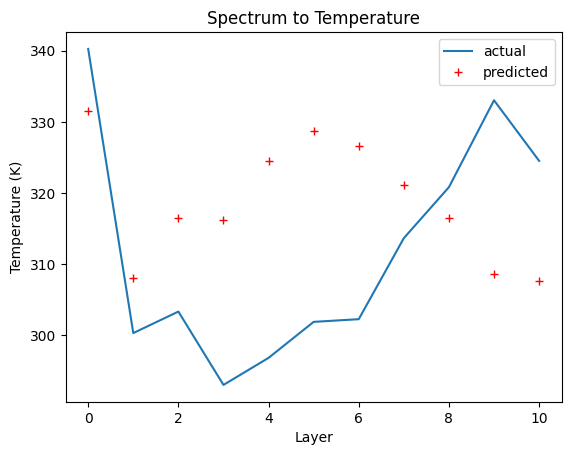

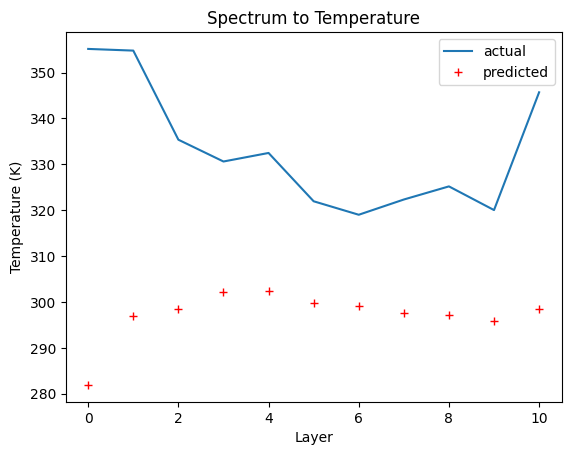

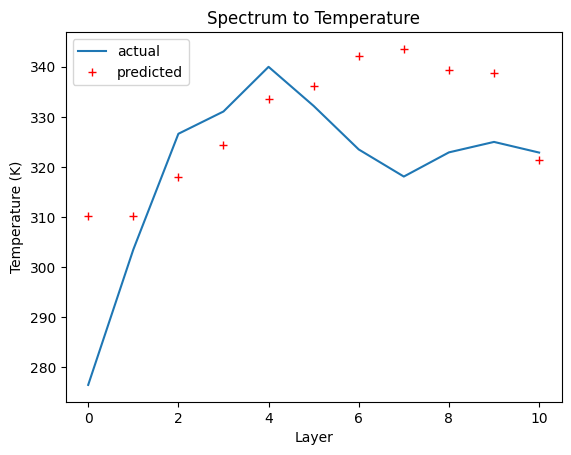

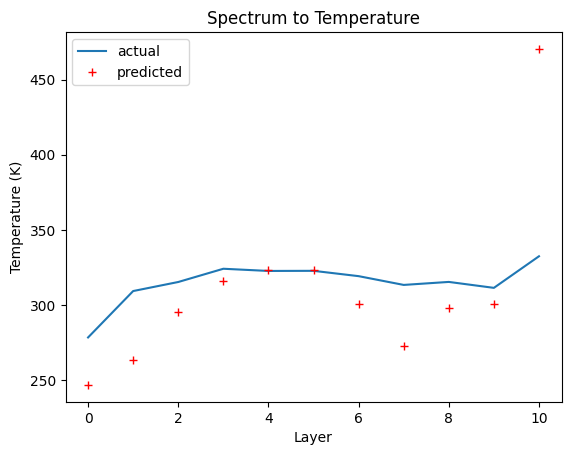

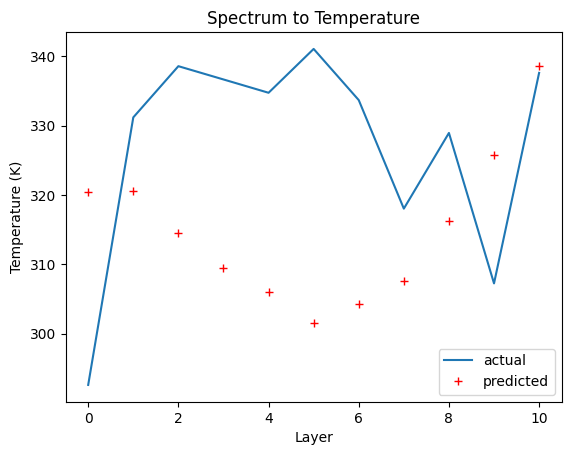

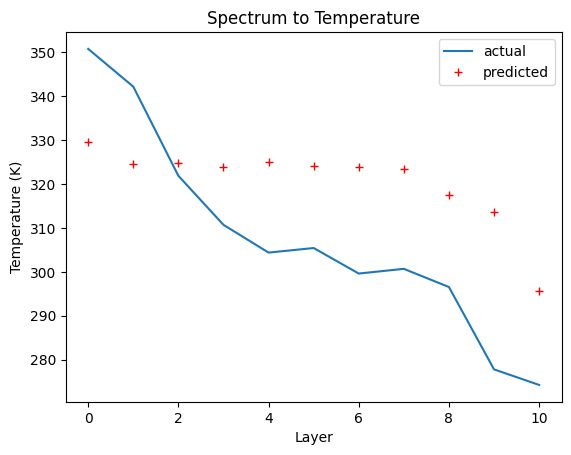

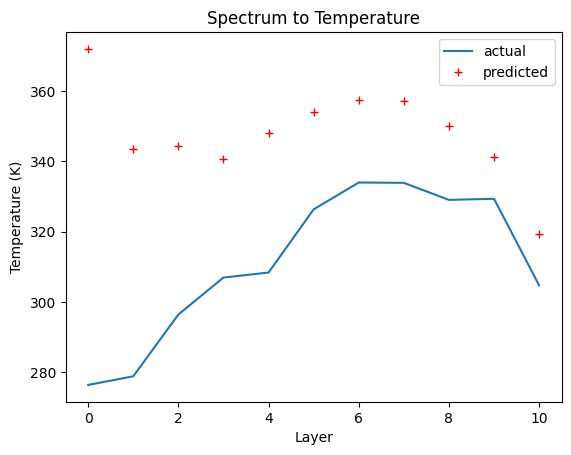

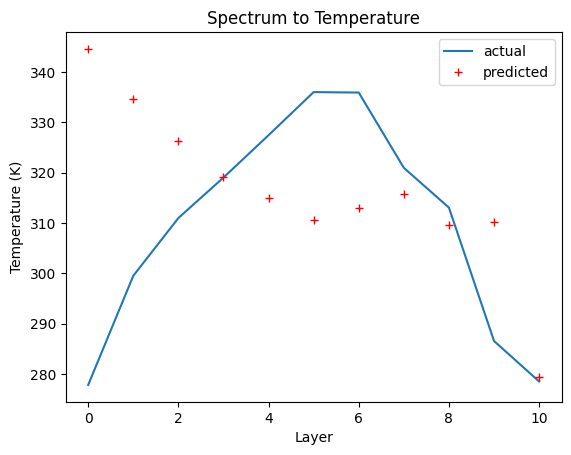

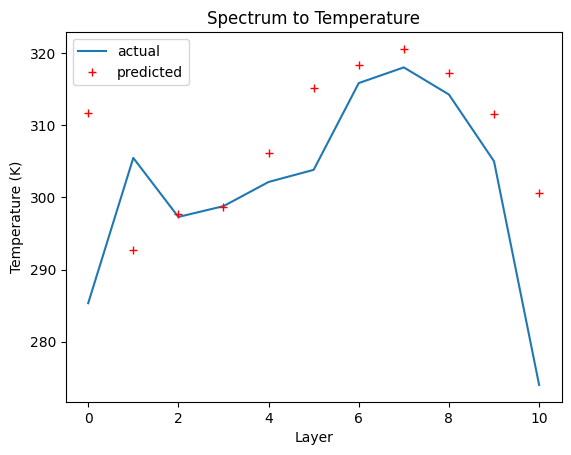

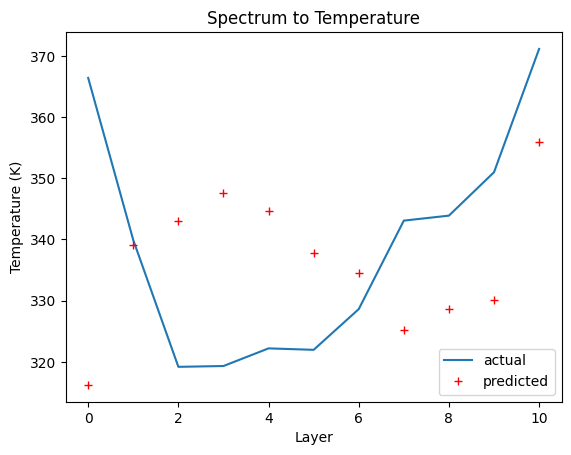

In [ ]:
for index in range(10):
    plot_actual_vs_pred(index*10)